# 0. 모듈 불러오기

In [1]:
import keras_ocr
import pytesseract
import os
import io
import cv2
from glob import glob
from PIL import Image, ImageDraw
from pytesseract import Output
from pytesseract import pytesseract as pt
import matplotlib.pyplot as plt
import matplotlib.image as img

print(keras_ocr.__version__)
print(pytesseract.__version__)

0.8.8
0.3.8


In [2]:
# 이미지 폴더 경로
data_path = os.getenv('HOME')+'/aiffel/ocr_python/images/'
os.listdir(data_path)

['.ipynb_checkpoints',
 'murat-onder-EWDCeCUz8Ho-unsplash.jpg',
 'nick-fewings-0y_DB18swVc-unsplash.jpg',
 'micah-boswell-00nHr1Lpq6w-unsplash.jpg',
 'hayley-murray-6Lf1kzL4AfY-unsplash.jpg',
 'bruno-figueiredo-uoteo7uO5OI-unsplash.jpg']

In [3]:
# 입력 이미지 경로 
images_path = glob(data_path+'*.jpg')
images_path

['/aiffel/aiffel/ocr_python/images/murat-onder-EWDCeCUz8Ho-unsplash.jpg',
 '/aiffel/aiffel/ocr_python/images/nick-fewings-0y_DB18swVc-unsplash.jpg',
 '/aiffel/aiffel/ocr_python/images/micah-boswell-00nHr1Lpq6w-unsplash.jpg',
 '/aiffel/aiffel/ocr_python/images/hayley-murray-6Lf1kzL4AfY-unsplash.jpg',
 '/aiffel/aiffel/ocr_python/images/bruno-figueiredo-uoteo7uO5OI-unsplash.jpg']

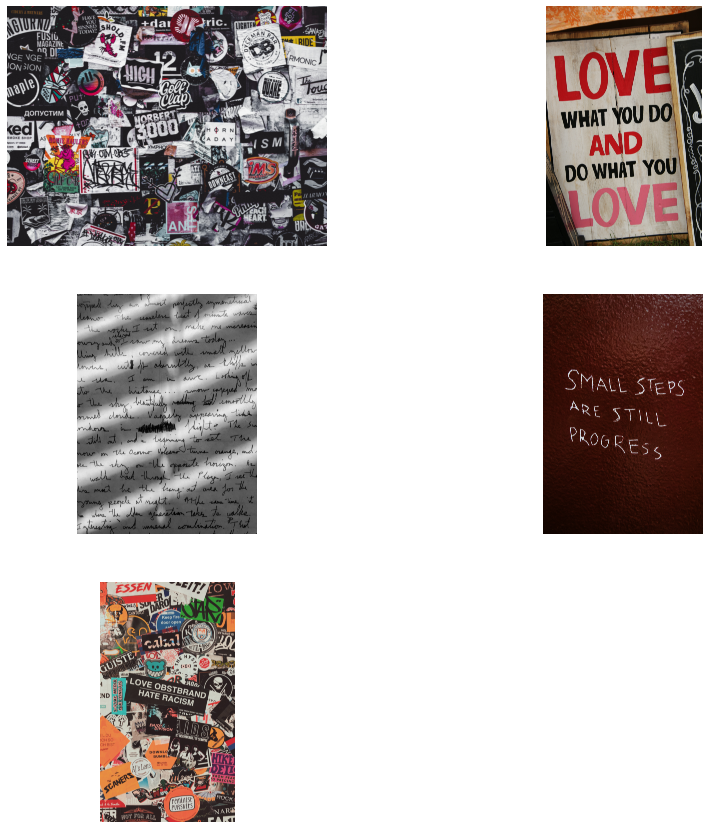

In [4]:
plt.figure(figsize=(15, 15))

for idx, image in enumerate(images_path):
    plt.subplot(3, 2, idx+1)
    im=img.imread(image)
    plt.imshow(im)
    plt.axis('off')

# 1. keras_ocr 

In [5]:
# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드받게 됩니다. 
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


In [6]:
images = [keras_ocr.tools.read(path) for path in images_path]

In [7]:
prediction_groups = [pipeline.recognize([path]) for path in images_path]

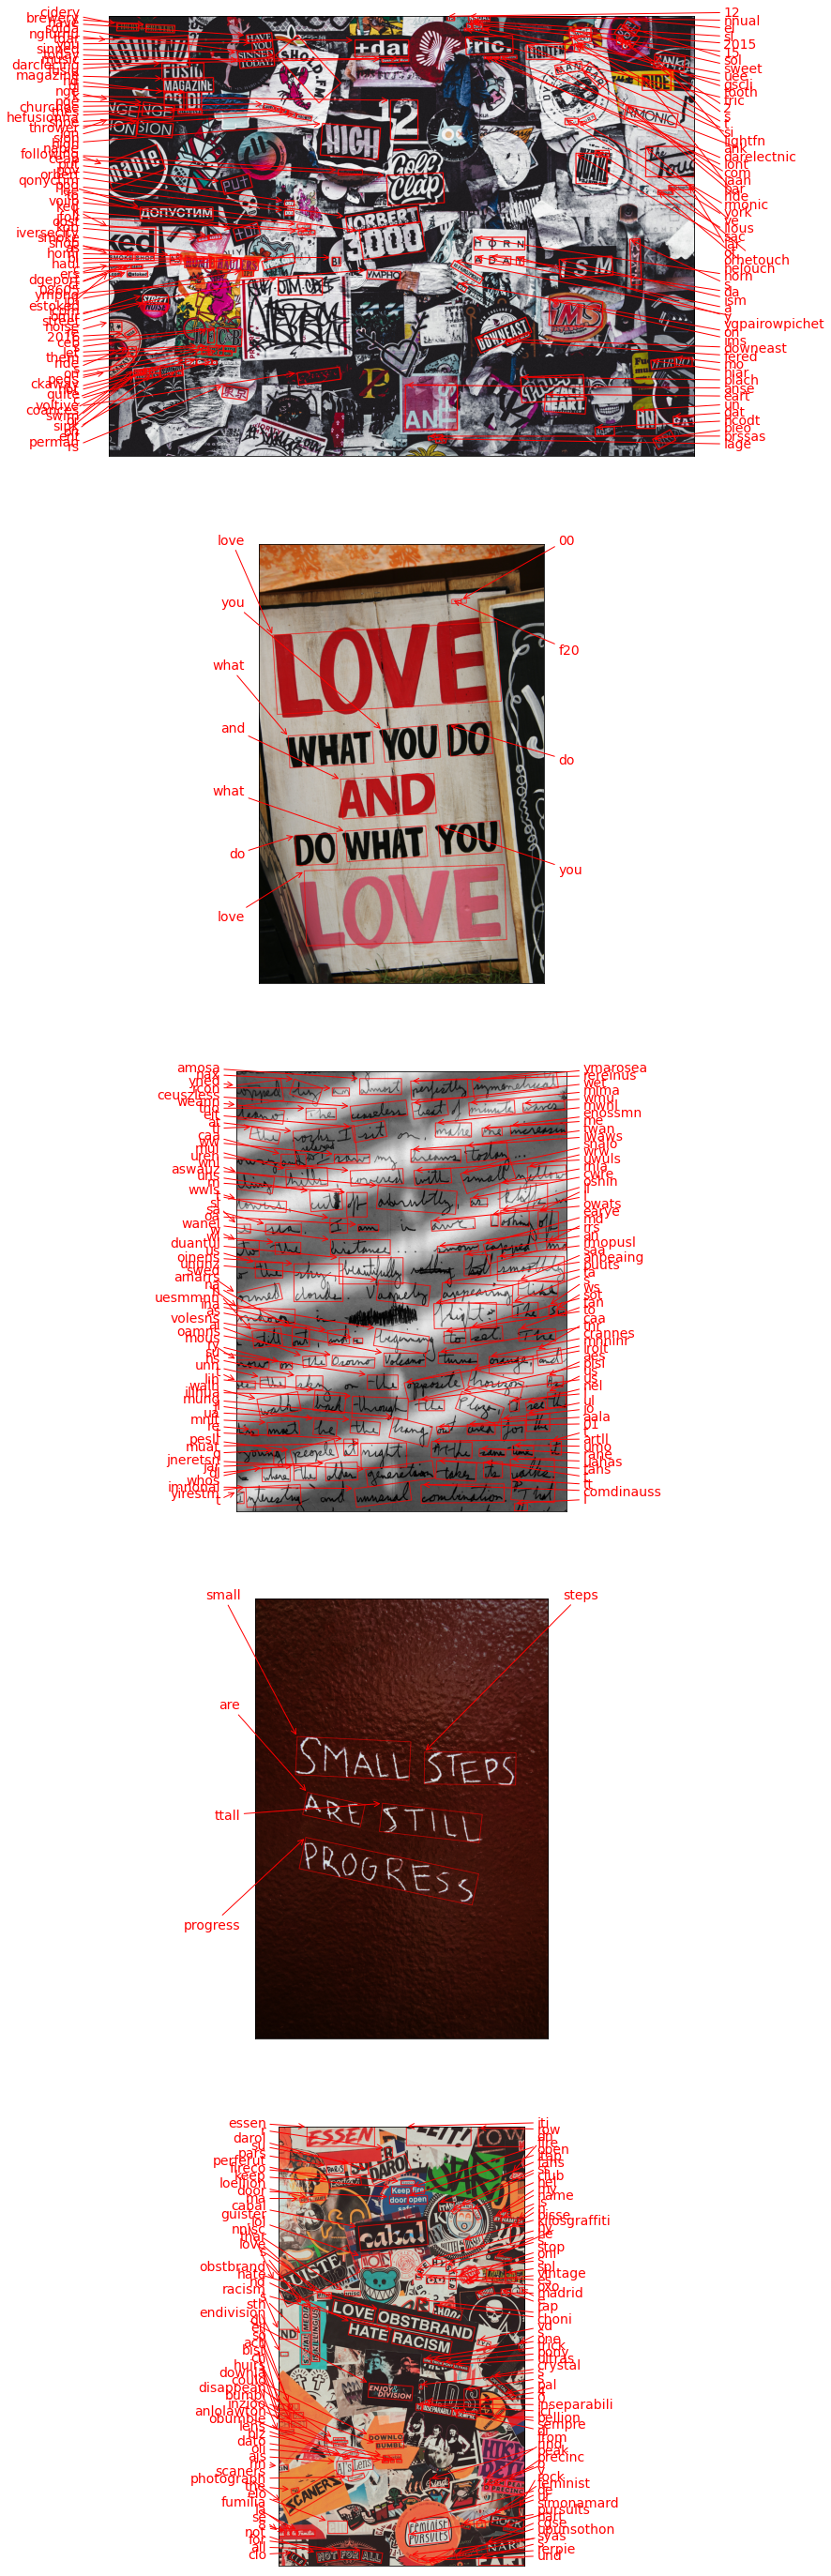

In [8]:
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(50, 50))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

# 2. 테서렉트
- 구글에서 후원하는 OCR 오픈소스 라이브러리.
- 한 번에 이미지 내의 문자 검출(detection)과 인식(recognition)을 할 수 있음.

In [9]:
def crop_word_regions(image_path, output_path):
    s = os.path.splitext(image_path)
    s = os.path.split(s[0])
    name = s[1]
    output_path = output_path + name +'/'
    
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 11'
    image = Image.open(image_path)
    img = cv2.imread(image_path)
    
    d = pt.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
#     n_boxes = len(d['text'])
#     for i in range(n_boxes):
#         if int(d['conf'][i]) > 60:
#             (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
#             img = cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
     
    top_level = max(d['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(d['level'])):
        level = d['level'][i]
    
        if level == top_level:
            left = d['left'][i]
            top = d['top'][i]
            width = d['width'][i]
            height = d['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return name, cropped_image_path_list, img


work_dir = os.getenv('HOME')+'/aiffel/ocr_python'
output_path = work_dir + '/output/' 

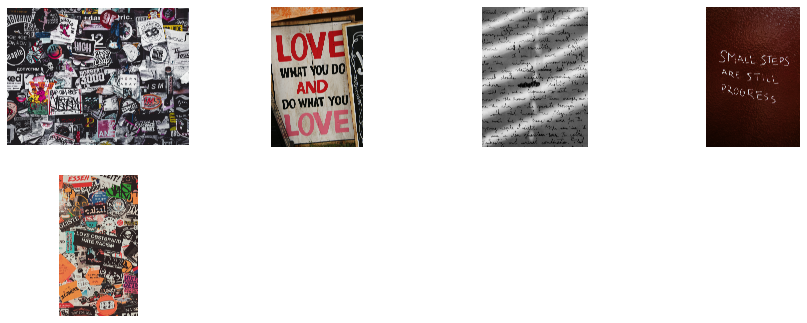

In [10]:
Tesser_dict = {}
img_dict = {}
plt.figure(figsize=(15, 15))

for idx, path in enumerate(images_path):    
    name, cropped_image_path_list, imgs = crop_word_regions(path, output_path)
    Tesser_dict[name] = cropped_image_path_list
    img_dict[name] = imgs
    plt.subplot(5, 4, idx+1)
    plt.imshow(imgs)
    plt.axis('off')

In [11]:
def recognize_images(cropped_image_path_list):
    test = []
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pt.image_to_string(
            image, lang='eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        test.append(recognized_data['text'].replace('\n', '').replace('\x0c',''))
        
    print(test)
    print("Done")
# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
recognize_images(cropped_image_path_list)

['By', '', '* a :', '', '>', 'RAIS', 'a', 'ZN', 'z', 'U8', 'ei’', '.', 'ARO', '', 'one', 'ELLY', 'Lae', 'a', 'fs', 'iTA', 'ry', 'C5', 'rANs', '“a', ')', 'ANC', ':', 'rrr:', 'KC', 'Ce eee', 'pa', '', 'y\\', '—', 'yy', '', '', 'r', 'a', 'Sa hr', 'Oe', 'uit TH', 'eg', 'oT', 'a at et', 'eee', 'eK By', 'Pe', 'ae', 'be', '7 cm', '4', 'ne', 'sa', 'a)', ':', '<¢', 'ie', '«', '\\', 'RY', '', 'f)', '.@', '~~ > fee', '(eXe)', 'ri', 'AY', 're 8a', 'iS', '', 'thar', 'Isc', '', '>', '\\_f)', 'Why', '', '4', 'B}', 'L OVE', '-HO', 'To', 'OC', '', '', 'mn | | mol', 'avs', 'Fu Ls', 'ATE', 'RAC', "S)it'<", 'arg', 'CHW', '"i', 'NE TRic', '', '©', "174 \\\\'", 'iS', '=', 'RS', '', 'SS', 'ay', 'S', '.', '\\ ale', 'Ra', 'IVIS', 'ION', 'en', 'y/', 'nS', '<9}', '', 'Ley', '—_ Poe', 'WN', 'Js', 'OwvrL Vv', 'a I', 'oe', '|', 'DISAPPEAR', 'y- 2400', '¥', '>', 'd*', 'e.', 'Avan', 'P', 'ells', 'i “', '),', 'i', 'iv', '€s.', '', '', 'NN', 'aay', 'XS', 'a', 'J', '&', 'a', 'ini@.', 'AY', 'an', '"', 'a &', '(', '', 'Fa

In [12]:
data_path = os.getenv('HOME')+'/aiffel/ocr_python/images/'
print(data_path)
print(os.listdir(data_path))

/aiffel/aiffel/ocr_python/images/
['.ipynb_checkpoints', 'murat-onder-EWDCeCUz8Ho-unsplash.jpg', 'nick-fewings-0y_DB18swVc-unsplash.jpg', 'micah-boswell-00nHr1Lpq6w-unsplash.jpg', 'hayley-murray-6Lf1kzL4AfY-unsplash.jpg', 'bruno-figueiredo-uoteo7uO5OI-unsplash.jpg']


# 3. keras-ocr 과 테서렉트 직접 비교
- 순서는 keras-ocr, 테서렉트 순으로 진행된다.

AxesSubplot(0.125,0.125;0.775x0.755)


<Figure size 7200x7200 with 0 Axes>

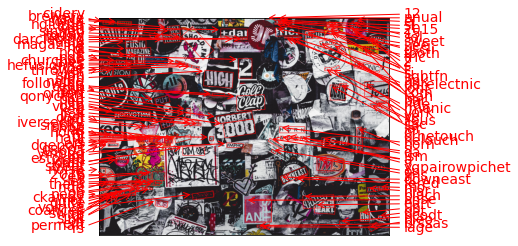

In [13]:
plt.figure(figsize=(100, 100))
a = keras_ocr.tools.drawAnnotations(image=images[0], 
                                    predictions=prediction_groups[0][0])
print(a)

['Loree’', 'ay', 'AL', 'aI', 'ais', 'i ae', ';', '}', '>', '"a', '<', 'ie:', '; . F ee = i', 'SweeG', '', 'Le', '[AVE', 'Ny', '‘Ye', 'Sey"', 'YOU', 'ao', 'ai', 'a', '(3', 'tT]', 'SINNED', 'ss', '', 'ja', '=', 'a', 'Deere ea', 'TODAY!', 'SHo,', 'Delis mtg me tesa', 'Soa', 'ic_hivs', 'i *', '.', '', '~ , = | a', 'WARN ZS', '<=', '- ea', 'aS', '1', '', 'z', '=>.', 'ys', 'gs 7', 'N?', 'WT eW aL', 'Bas', 'DSS', 'iS', 'a', 'tN', 'abate', 'RIDE', 'o', '', ' .', 'ts', 'XN]', 'CHI', 'a.', 'wae', 'ao', 'JQ', 'p', '+, ¥', '¥', 'f,', '', 'RC', 'OF', 'Tye', 'S', 'a SC', 'VGE', 'NGE', 'see tes', '—_—', 'HSH', 'Of', 'THR9', 'WEP', 'ya', '‘', 'S', '-\\', '', 'a', 'RMONIC', 'a', '4', 'i ae', 'pez', '_—', 'ae', 'ee,', ':', 'mel)', 'V4,', '—_—', 'NSy', 'e.', 'A\\ |', 'e', 'se', 'MM', '', 'oy', 'ne Pee eh Lk', 'ACE', '', '\\\\\\', 'y-. SC', 'Ten tc', '\\"', 'NY,', '', 'a', 'OUR', 'AE', 'ae', 'ae”', 'jute', '@thetouch c', '>', '', 'ee', 'Ey «', ')', 'hetouch', "') mee!) |", '1]', '|', '> *', 'r', '=', '', 

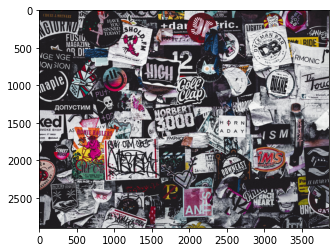

In [14]:
plt.imshow(img_dict['murat-onder-EWDCeCUz8Ho-unsplash'])
# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
recognize_images(Tesser_dict['murat-onder-EWDCeCUz8Ho-unsplash'])

keras-ocr은 detection은 한 걸로 보이지만 완벽히 recognition을 했는지를 plot을 통해 확인할 수 없고, 테서렉트는 제대로 detection 하는 것이 많지 않다.

AxesSubplot(0.125,0.125;0.775x0.755)


<Figure size 7200x7200 with 0 Axes>

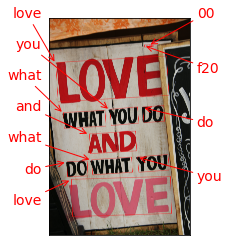

In [15]:
plt.figure(figsize=(100, 100))
a = keras_ocr.tools.drawAnnotations(image=images[1], 
                                    predictions=prediction_groups[1][0])
print(a)

['A |', '', 'hy', 'E', '|', '|', '', '.', '|', '\\', '|', '', 'OU', 'WHAT', 'p', '\\', 'a)', '@>', '“', '’', '\\y"', '1', '|', 'HO', 'WHAT', 'YOU', '', ',', '7', 'bj', 'a', '', '—', '', 'Sea’', '-']
Done


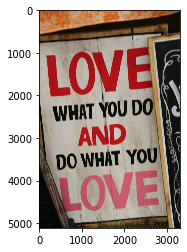

In [16]:
plt.imshow(img_dict['nick-fewings-0y_DB18swVc-unsplash'])
# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
recognize_images(Tesser_dict['nick-fewings-0y_DB18swVc-unsplash'])

keras-ocr은 사진에 나와 있는 모든 글자를 detection하고 recognition이 훌륭히 수행된데 반해, 테서렉트는 가장 크게 쓰여있는 LOVE 조차 recognition하지 못하고 있다.

AxesSubplot(0.125,0.125;0.775x0.755)


<Figure size 7200x7200 with 0 Axes>

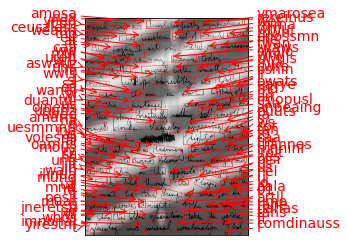

In [17]:
plt.figure(figsize=(100, 100))
a = keras_ocr.tools.drawAnnotations(image=images[2], 
                                    predictions=prediction_groups[2][0])
print(a)

['»', '<', 'ate', 'WM', 'Gr', 'i', 'fi', '', 'ae', 'IP', '', '5', '7', ':', 'i)', 'J}', 'Yh |', 'a', '—e', ':', '|', ':', ',', 'iy', 'ly', 'ft Zi', 'TAs.', 'On LUNA', 'P|', '-', 'oi', '']
Done


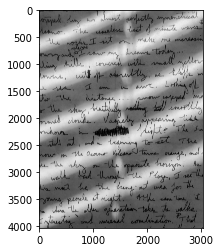

In [18]:
plt.imshow(img_dict['micah-boswell-00nHr1Lpq6w-unsplash'])
# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
recognize_images(Tesser_dict['micah-boswell-00nHr1Lpq6w-unsplash'])

이 텍스트는 나조차도 recogniton하지 못하기 때문에 분석을 포기한다. recognition부분을 제외한 detection 부분만 본다면 keras-ocr이 테서렉트보다 detection을 잘 하는 모습을 보이고 있다.

AxesSubplot(0.125,0.125;0.775x0.755)


<Figure size 7200x7200 with 0 Axes>

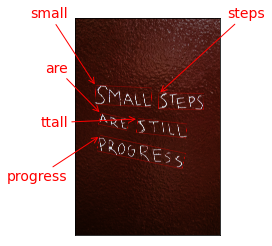

In [19]:
plt.figure(figsize=(100, 100))
a = keras_ocr.tools.drawAnnotations(image=images[3], 
                                    predictions=prediction_groups[3][0])
print(a)

['-.', '~', '', '2', 'pada’', '+;', 'oy', 'fe', ',.', 'es', 'Lae»', '', '', '¥', '', 'ate', '-', 'ye', '', 'ey', 'te', 'at', '=:', 'i', '.', 'he', '=', 'a Xe.', 'Ps', '', 'ae.', '', '=', 'i', '»', 'ae', '~~', 'ees', '', '“ee,', 'ats', '', '', '', 'A,', 'ets', '> al', '', 'ye', 'rd', 'Se', '’', '1”', '', '', 'me', 'iy', 'ay', '', 'a,', 'it', 'a', '.', '', '', '=~', 're', '', 'By', '', '', '', '“io', '3', 'oe', 'oo', 'al', 'i', '> aes', 'rae', '= ans', '*', 'tes:', '_—', 'a Ea', 'a in', '', '', '', 'a', 'dts', 'a', 'et', 'iP', '> “Se - %', 'ae', '', 'De', '', 'wt «', 'see', '', 'bot', 'i', '', 'ms Sis', '', 'TF', 'ee', '~~', '', '..', '—s', 'sa', 'ex *', '', '', 'ie', '<', '4', 'ps', '#', 'éiea', 'z.', '‘', '‘', '', '', '', '', 'ro', '_ a.', 'Wo baa', 'oe', '', 'ee ce', 'i os', '', 'be cree’', 'Kae', '', 'a', '', 'a', 'ee,', '', 'ae', '> =', 'crn', '', 'rae', '', '«ees ee', 've', '', 'ae.', 'eR:', '', 'ee', '~ “SVS', 'ee he 4,', 'hee', '“a', 'pa', '.*', '', 'ss', '', '.', '', 'wan', '‘',

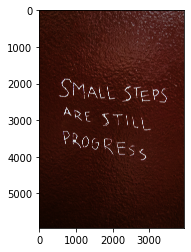

In [20]:
plt.imshow(img_dict['hayley-murray-6Lf1kzL4AfY-unsplash'])
# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
recognize_images(Tesser_dict['hayley-murray-6Lf1kzL4AfY-unsplash'])

keras-ocr은 detection은 잘 됐지만, recognition이 'still' 한 단어를 제외하고 잘 이루어지고 있다. 테서렉트는 위 문장 중에서 어느 것조차 인식을 못하고 있는 모습을 보이고 있다.

AxesSubplot(0.125,0.125;0.775x0.755)


<Figure size 7200x7200 with 0 Axes>

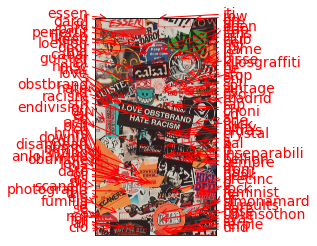

In [21]:
plt.figure(figsize=(100, 100))
a = keras_ocr.tools.drawAnnotations(image=images[4], 
                                    predictions=prediction_groups[4][0])
print(a)

['By', '', '* a :', '', '>', 'RAIS', 'a', 'ZN', 'z', 'U8', 'ei’', '.', 'ARO', '', 'one', 'ELLY', 'Lae', 'a', 'fs', 'iTA', 'ry', 'C5', 'rANs', '“a', ')', 'ANC', ':', 'rrr:', 'KC', 'Ce eee', 'pa', '', 'y\\', '—', 'yy', '', '', 'r', 'a', 'Sa hr', 'Oe', 'uit TH', 'eg', 'oT', 'a at et', 'eee', 'eK By', 'Pe', 'ae', 'be', '7 cm', '4', 'ne', 'sa', 'a)', ':', '<¢', 'ie', '«', '\\', 'RY', '', 'f)', '.@', '~~ > fee', '(eXe)', 'ri', 'AY', 're 8a', 'iS', '', 'thar', 'Isc', '', '>', '\\_f)', 'Why', '', '4', 'B}', 'L OVE', '-HO', 'To', 'OC', '', '', 'mn | | mol', 'avs', 'Fu Ls', 'ATE', 'RAC', "S)it'<", 'arg', 'CHW', '"i', 'NE TRic', '', '©', "174 \\\\'", 'iS', '=', 'RS', '', 'SS', 'ay', 'S', '.', '\\ ale', 'Ra', 'IVIS', 'ION', 'en', 'y/', 'nS', '<9}', '', 'Ley', '—_ Poe', 'WN', 'Js', 'OwvrL Vv', 'a I', 'oe', '|', 'DISAPPEAR', 'y- 2400', '¥', '>', 'd*', 'e.', 'Avan', 'P', 'ells', 'i “', '),', 'i', 'iv', '€s.', '', '', 'NN', 'aay', 'XS', 'a', 'J', '&', 'a', 'ini@.', 'AY', 'an', '"', 'a &', '(', '', 'Fa

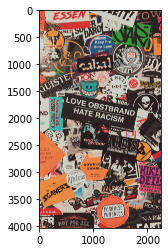

In [22]:
plt.imshow(img_dict['bruno-figueiredo-uoteo7uO5OI-unsplash'])
# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
recognize_images(Tesser_dict['bruno-figueiredo-uoteo7uO5OI-unsplash'])

위와 같은 양상을 보이고 있다. keras-ocr이 더 detection과 recognition을 잘 하고 있는 모습을 보여준다.

# 4. keras-ocr과 테서렉트 직접 비교 정리
- keras-ocr은 한글 지원이 안되지만, 테서렉트는 한글 지원이 된다.
- keras-ocr은 가독성이 좋지만, 테서렉트는 가독성이 형편 없다.
- keras-ocr이 디텍션을 더 잘 하는 것 같다.

# 출처
https://github.com/Wongi-Choi1014/Korean-OCR-Model-Design-based-on-Keras-CNN

https://github.com/hotsun1508/Aiffel/blob/main/Exploration/%5BE-15%5DDeep_Learning_OCR.ipynb

https://unsplash.com/s/photos/text

# 회고

- OCR을 통해 detection과 recognition을 실습해보았다. detection과 recognition을 실습해 볼 수 있어서 좋았다. 한글어 모델이 적용된 keras_ocr를 써보면 더 좋았을 거라는 아쉬움이 든다.
- prediction하는 과정이 오래 걸렸다. 아무래도 많은 단어가 있는 사진을 선택해서 그런 것 같다. 
- 테서렉트보다 keras-ocr이 더 가독성이 좋아서 아무래도 keras-ocr로 나중에 모델을 만들어 보고 싶다는 생각이 들었다.